# Reply Tool AB Test Report

**Megan Neisler**  

 Data Scientist, Wikimedia Foundation
 
March 2021

[Task](https://phabricator.wikimedia.org/T252057)

# ABSTRACT

FIXME: TO BE ADDED

# Introduction

The Wikimedia Foundation's Editing team is working to improve how contributors communicate on Wikipedia using talk pages through a series of incremental improvements that will be released over time.

As part of this effort, the Editing team introduced a new workflow for replying to specific comments with the intention of making participating productively on talk pages easier and more intuitive. The reply tool is an extra button that appears at the end of a post on a talk page (as shown in Figure 1). When you click on it, it opens a reply form that makes replying to that post easier to do correctly. It indents correctly, helps ping correctly, and automatically signs correctly for you, among other things. 

![Figure 1: Screenshot of Reply Tool](Figures/DiscussionTools_Reply_visual_2021.png "Figure 1: Screenshot of Reply Tool")
*Figure 1: Screenshot of Reply Tool*

The team ran an AB test of the Reply Tool from 11 February 2021 through 10 March 2021 to assess the efficacy of this new feature. The test included logged-in users that had not used the Reply Tool before (defined as people whose discussiontools-editmode preference is empty) and  attempted an edit at one of the 22 paticipating Wikipedias (see full list of [participating Wikipedias](https://www.mediawiki.org/wiki/Talk_pages_project#Active_initiatives)). 


During this test, 50% of all users at the Wikipedias included in the test will have the Reply tool automatically enabled, and 50% will not. Users at these Wikipedias will still be able to turn the tool on or off in Special:Preferences. 

The results of this test will help the team decide whether people benefit enough from the tool for it to begin being made available by default, at all projects. 

Upon conclusion of the test on 10 March 2021, a total of X edit attempts had been completed across both groups.

You can find more information about features of this tool and project updates on the [project page](https://www.mediawiki.org/wiki/Talk_pages_project/Replying).

# Purpose

The purpose of the AB test is to understand whether enabling the Reply tool causes a greater percentage of Junior Contributors to publish the comments they start without a significant increase in disruption. We will assess disruption by looking at the number of edits made to talk pages that are reverted within 48 hours and the number of editors who are blocked after making an edit to a talk page.

The results of this analysis will be used to determine if the Reply Tool should be deployed to all people, at all wikis, as an opt-out user preference. Please see further details about the hypotheses and descision scenarios in the [task description](https://phabricator.wikimedia.org/T252057).



# Methodology

In [184]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
     # Essentials:
library(zeallot) # multi-assignment operator %<-%
library(tidyverse)
# Presentable tables:
library(gt)
library(gtsummary)
# Modelling:
library(lme4)
library(brms)
library(tidybayes)
})

The AB test was a run on a per wiki basis and users included in the test were randomly assigned to either the control (reply tool disabled by default) or treatment (reply tool enabled by default) using their user ID. Users within each group also had the option to explicilty turn the tool on or off in their preferences; however, these users remained in the same group they were bucketed in for the duration of the test. 

Data was collected in the EditAttemptStep event logging table. We excluded data from from Feb 25 to March 1 in this analysis due to an [error](https://gerrit.wikimedia.org/r/c/mediawiki/extensions/WikimediaEvents/+/667690) in the Sampling configuration that resulted in the loss of Visual Editor/Wikieditor data. 

In this test, there are two primary methods to complete a reply (Page Edit and Reply Tool). For the purpose of this analysis, these two types of edits are defined as follows: 

**Page Edit:**: Any edit to a page in a talk namespace that were not edits to create new sections or pages and not made with the reply tool. It's possible that some of the edits were corrective edits (i.e fixing a signature) but current instrumentation does not decipher between this type of edit and a reply. These events were sampled at a rate of 1/16, or 6.125%

Recorded in the EditAttemptStep as:  `event.action = 'init'`, `event.integration = 'page'` , `event.init_type = 'section' or 'page'`, `event.init_mechanism = 'click'`


**Reply Tool:** Any edit made with the reply tool to a page in a talk namespace. With available instrumentation, we can confirm that all edits made with the reply tool were responses to a comment on the page and not a correction edit. These events were sampled at 100%. 

Recorded in EditAttemptStep as: `event.action = 'init'`, `event.integration = 'discussiontools'`, `event.init_type = 'page'`

See the following Phabricator tickets for further details regarding instrumentation and implementation of the AB test:

* Enable AB Test [T273554](https://phabricator.wikimedia.org/T273554)
* AB Test turned off. [T276967](https://phabricator.wikimedia.org/T276967)
* AB Test Instrumentation Changes [T273096](https://phabricator.wikimedia.org/T273096)
* AB Test QA [T268193](https://phabricator.wikimedia.org/T268193)
* AB Test Bucket Implementation [T268191](https://phabricator.wikimedia.org/T268191)


# Data Exploration

In [187]:
# Collect data on talk page edit attempts exluding new section edits

query <-
"
SELECT
    date_format(dt, 'yyyy-MM-dd') AS attempt_dt,
    wiki AS wiki,
    event.user_id AS user_id,
    event.editing_session_id AS edit_attempt_id,
    event.integration AS editor_type, 
    event.editor_interface AS editor_interface,
    event.bucket AS test_group,
    event.is_oversample AS is_oversample,
    If(event.integration == 'discussiontools', 1, 0) AS reply_tool_used,
-- define edit attempt outcomes as 1 if the edit was published and 0 if it was not 
    If(event.action == 'saveSuccess', 1, 0) AS edit_success,
    CASE
        WHEN min(event.user_editcount) is NULL THEN 'undefined'
        WHEN min(event.user_editcount) < 100 THEN 'under 100'
        WHEN (min(event.user_editcount) >=100 AND min(event.user_editcount < 500)) THEN '100-499'
        ELSE 'over 500'
        END AS edit_count
FROM event.editattemptstep
WHERE
    wiki IN ('frwiki', 'eswiki', 'itwiki', 'jawiki', 'fawiki', 'plwiki', 'hewiki', 'nlwiki',
    'hiwiki', 'kowiki', 'viwiki', 'thwiki', 'ptwiki', 'bnwiki', 'arzwiki', 'swwiki', 'zhwiki',
    'ukwiki', 'idwiki', 'amwiki', 'omwiki', 'afwiki')
-- AB test deployed on Feb 11th and ended on the 10th 
    AND year = 2021 
    AND ((month = 02 AND day >= 12) OR (month >= 03 AND day < 10))
-- look at only desktop events
    AND event.platform = 'desktop'
-- review all talk namespaces
    AND event.page_ns % 2 = 1
-- only users in AB test
    AND event.bucket IN ('test', 'control')
-- discard VE/Wikiditor edits to create new page or section or new discussion tool edits
    AND NOT ((event.action = 'init' AND (event.init_mechanism = 'url-new' OR event.init_mechanism == 'new'))
    OR (event.action = 'init' AND (event.init_type = 'section' AND event.integration ='discussiontools')))
    -- remove bots
    AND useragent.is_bot = false
    AND event.user_id !=0
GROUP BY
    date_format(dt, 'yyyy-MM-dd'),
    wiki,
    event.user_id,
    event.editing_session_id,
    event.integration,
    event.bucket,
    event.editor_interface,
    event.is_oversample,
    If(event.integration == 'discussiontools', 1, 0),
    If(event.action == 'saveSuccess', 1, 0) 
"

In [188]:
collect_ab_edit_attempts <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [189]:
# saving file 

write.csv(collect_ab_edit_attempts, file = "Data/ab_edit_attempts.csv")

In [190]:
# reformat to date format
collect_ab_edit_attempts$attempt_dt <- as.Date(collect_ab_edit_attempts$attempt_dt, format = "%Y-%m-%d")


In [191]:
#clarfiy levels and lables for factor variables
collect_ab_edit_attempts$editor_type <- factor(collect_ab_edit_attempts$editor_type, levels = c("page", "discussiontools"), labels = c("Page Edit", "Reply Tool"))
collect_ab_edit_attempts$edit_count <- factor(collect_ab_edit_attempts$edit_count, levels = c("under 100", "100-499", "over 500"))


In [192]:
# remove data from dates where EditAttempt Stemps events were not sampled correctly.

collect_ab_edit_attempts <- collect_ab_edit_attempts %>%
    filter(attempt_dt < '2021-02-25' | attempt_dt > '2021-03-01')

In [193]:
collect_ab_edit_attempts$user_id<- as.character(collect_ab_edit_attempts$user_id) 


## Data Distribution

Edit Completion Rate defined as the percent of edit attempts that were published. 

Note: We also considered defining edit completion rate as the percent of all users that made at least 1 sucessful edit (see scratchpad section below to see results of that analysis).

### Edit Completion Rate 

#### Overall

In [196]:
# Review edit attempts by event type and wiki
ab_edit_attempts_all <- collect_ab_edit_attempts %>%
    group_by (editor_type) %>%
    summarise(n_users = n_distinct(user_id),
              n_attempts = n_distinct(edit_attempt_id),
             completion_rate = round(sum(edit_success)/n_attempts, 2))

ab_edit_attempts_all

`summarise()` ungrouping output (override with `.groups` argument)



editor_type,n_users,n_attempts,completion_rate
<fct>,<int>,<int>,<dbl>
Page Edit,2646,5592,0.58
Reply Tool,2037,4583,0.61


#### By Wiki

In [197]:
# Review edit attempts by event type and wiki
ab_edit_attempts_bywiki <- collect_ab_edit_attempts %>%
    group_by (wiki, editor_type) %>%
    summarise(n_users = n_distinct(user_id),
              n_attempts = n_distinct(edit_attempt_id),
              completion_rate = round(sum(edit_success)/n_attempts, 2))

ab_edit_attempts_bywiki

`summarise()` regrouping output by 'wiki' (override with `.groups` argument)



wiki,editor_type,n_users,n_attempts,completion_rate
<chr>,<fct>,<int>,<int>,<dbl>
afwiki,Page Edit,4,6,0.67
afwiki,Reply Tool,1,4,1.00
arzwiki,Page Edit,8,9,0.22
arzwiki,Reply Tool,3,4,0.50
bnwiki,Page Edit,28,52,0.71
bnwiki,Reply Tool,18,46,0.80
eswiki,Page Edit,423,1184,0.69
eswiki,Reply Tool,322,558,0.61
fawiki,Page Edit,134,219,0.48


In [116]:
options(repr.plot.width = 15, repr.plot.height = 10)

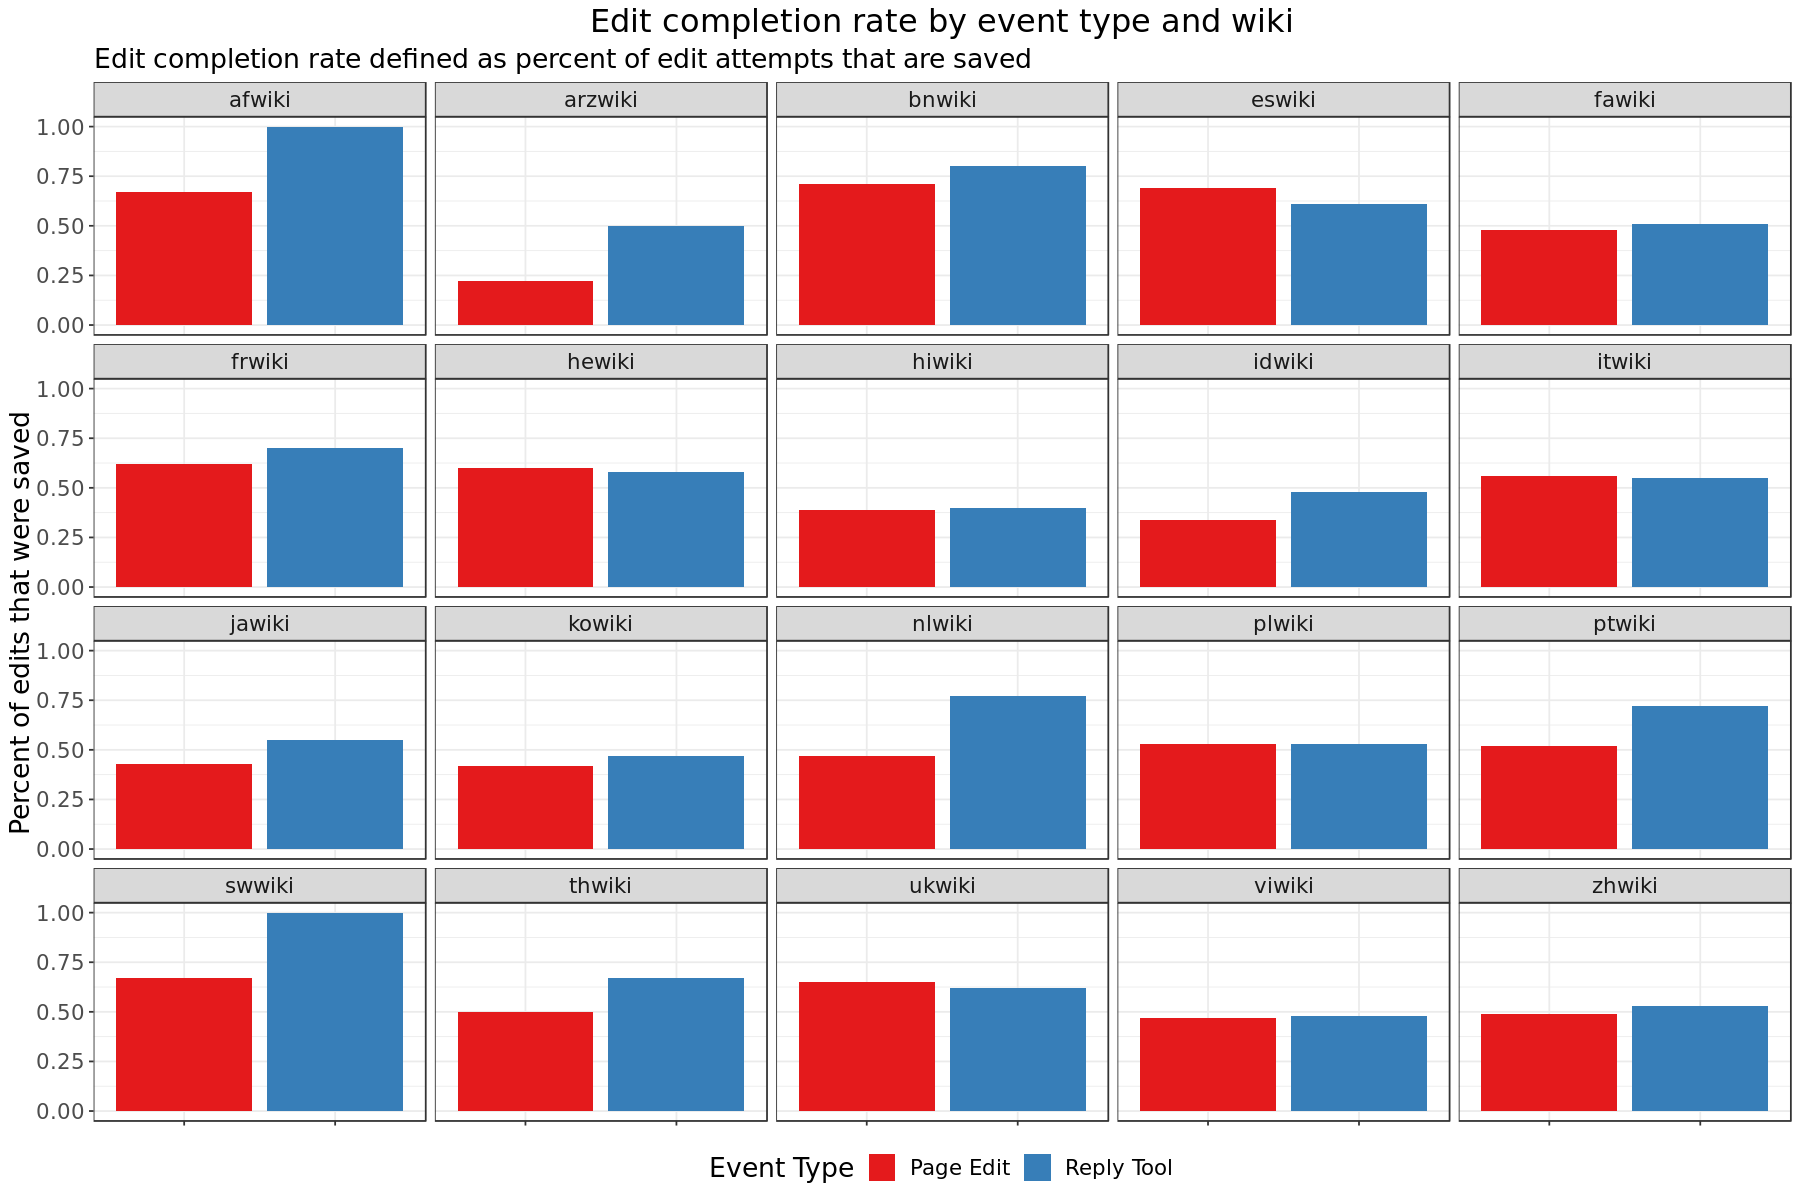

In [199]:
# Plot edit completion rates for each user on each wiki and each 

p <- ab_edit_attempts_bywiki  %>%
    ggplot(aes(x= editor_type, y = completion_rate, fill = editor_type)) +
    geom_col(position = 'dodge') +
    facet_wrap(~ wiki) +
    labs (y = "Percent of edits that were saved ",
          x = "Editor Type",
          title = "Edit completion rate by event type and wiki",
          subtitle = 'Edit completion rate defined as percent of edit attempts that are saved')  +
    theme_bw() +
    scale_fill_brewer(name="Event Type", palette="Set1")  +
    theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        legend.position = "bottom")
      
p

Overall reply attempts made with the reply tool had a higher completion rate than page edits. The results vary on a per wiki basis. On a per wiki basis, the reply tool had a higher edit completion rate on all participating wikis except 'ukwiki', 'hewiki', 'itwiki, and 'eswiki'.

In [202]:
# two-way contingency table of categorical outcome and predictors we want
## to make sure there are no 0 cells
xtabs(~edit_success + reply_tool_used, data = collect_ab_edit_attempts)

            reply_tool_used
edit_success    0    1
           0 5604 4787
           1 3233 2804

`summarise()` regrouping output by 'edit_count', 'editor_type' (override with `.groups` argument)



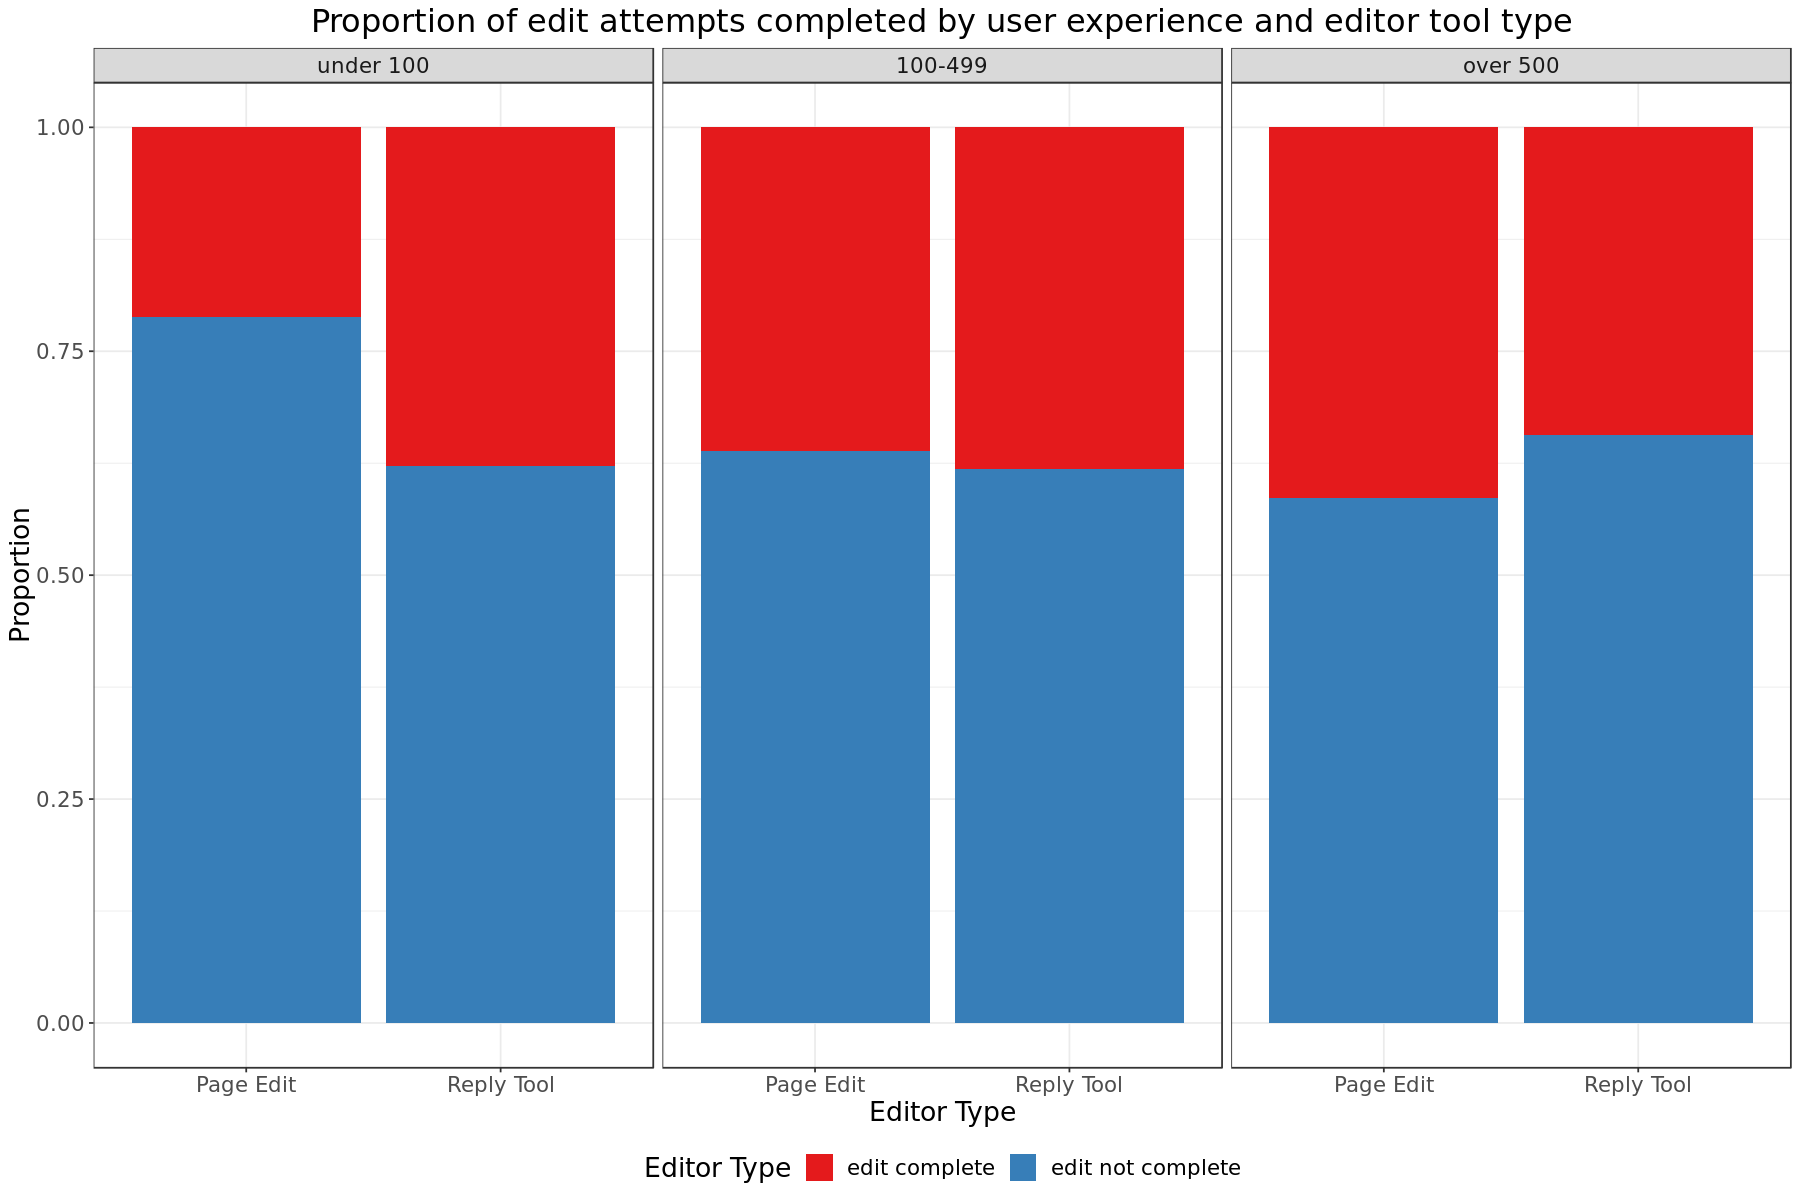

In [205]:
# plot proportion of edit complets by use of reply tool and experience level

p <- collect_ab_edit_attempts %>%
    group_by(edit_count, editor_type) %>%
    summarise(edit_success = ifelse(edit_success == 1, 'edit complete', 'edit not complete')) %>%
    ggplot(aes(x= editor_type , fill = edit_success)) +
    geom_bar(position = "fill") +
    facet_grid(~ edit_count) +
    labs (y = "Proportion",
              x = "Editor Type",
             title = "Proportion of edit attempts completed by user experience and editor tool type")  +
        theme_bw() +
        scale_fill_brewer(name="Editor Type", palette="Set1")  +
        theme(
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            legend.position = "bottom")

p

The figure above compares the proportion of edit attempts that were completed by editor tool and edit count. The data suggests that more user experience is associated with a higher likelihood of edit completion rate. 

Junior Contributors (users with under 100 cumulative edits) saw the biggest increase in edit completion rate with the Reply tool compared to replies by editing the page using the previously available workflows. 


## Simple Logistic Regression Model

We first start with just a standard linear regression where use of the reply tool is the only predictor. In this case, we use logistic regression model as the outcome (edit complete or not complete) is a binary variable. This model treats all edit attempts as independent and identically distributed and does not account from the effect of the user on the success probability of an edit. 

In [206]:

ec_glm <- glm(
    formula = edit_success ~ reply_tool_used, 
    family = binomial(link = 'logit'),
    data = collect_ab_edit_attempts, 
             )

In [207]:
summary(ec_glm) 
#FIXME: Reformat into more readable table


Call:
glm(formula = edit_success ~ reply_tool_used, family = binomial(link = "logit"), 
    data = collect_ab_edit_attempts)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9603  -0.9603  -0.9544   1.4113   1.4181  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -0.55007    0.02209 -24.907   <2e-16 ***
reply_tool_used  0.01521    0.03245   0.469    0.639    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 21606  on 16427  degrees of freedom
Residual deviance: 21606  on 16426  degrees of freedom
AIC: 21610

Number of Fisher Scoring iterations: 4


The simple logistic regression model estimates the coefficients as β0 = -0.55 and β1 = 0.015, where β0 is the intercept and β1 is the slope and effect associated with using the reply tool on completing an edit. 

Since the model parameters are on the log-odds scale, we take the exponentiation of the effect (exp(β1))to determine the multiplicative effect on the odds of an edit getting published

The estimates provided by the model indicate that odds of a user completing an edit with the reply tool is slightly higher (1.02 times) than the odds of a user completing an edit using  page or section editing; however, this does not take into account the effect of the user themselves or their experience.



## Hierarchical Logistic Regression Model

Next we'll run a mixed model to include unique effect of the users. We used a Hiearchical regression model to model this structure since individual edit attempts are grouped by wiki and users within that wiki.

In this model, the user and wiki are random effects and whether the reply tool was used is a fixed effect or predictor variable. 

To account for both wiki and user_id, we allow the intercept, represented by 1, to vary among  wiki and users within the wiki.

In [235]:
# Mixed effect 
# The (1|user_id) means that we are allowing the intercept, represented by 1, to vary by user

ec_hrm = glmer(
    formula = edit_success ~ reply_tool_used + (1 | wiki/user_id), 
    family = binomial(link = "logit"), 
    data = collect_ab_edit_attempts
) 

In [236]:
summary(ec_hrm)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: edit_success ~ reply_tool_used + (1 | wiki/user_id)
   Data: collect_ab_edit_attempts

     AIC      BIC   logLik deviance df.resid 
 21585.0  21615.9 -10788.5  21577.0    16424 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.8881 -0.7702 -0.7248  1.2754  1.4456 

Random effects:
 Groups       Name        Variance Std.Dev.
 user_id:wiki (Intercept) 0.007553 0.08691 
 wiki         (Intercept) 0.010445 0.10220 
Number of obs: 16428, groups:  user_id:wiki, 4328; wiki, 20

Fixed effects:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -0.62282    0.03867 -16.107   <2e-16 ***
reply_tool_used  0.05144    0.03406   1.511    0.131    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
reply_tl_sd -0.438

### Interpreting the Results

The Hiearchical regression model has estimated a larger effect of the reply tool on edit completion rate.  We can also confirm the statistically significant association between whehter the reply tool is used and the odds of completing an edit (after controlling for the random effects by the wiki and users within each wiki).

The estimates provided by this model indicate that odds of a user completing an edit with the reply tool is slightly higher (1.05 times) than the odds of a user completing an edit using  page or section editing.

OR (from Mikhail's report)

The maximum lift in edit attempt success probability is 1.2% (95% CI: -0.4%-2.8%); however,  because the confidence interval includes 0 this is not statistically significant at the 0.05 level. 

When using the reply tool, the odds of saving the edit are multiplied by 1.05 (95% CI: 0.98-1.12). We can also confirm statistical signficance (at the 0.05 level) since the confidence interval does not contain 1 (a multiplicative effect of 1 is no change either way).

The variance shows how much, on average, the edit completion rate varies user to user.

## Bayesian Hierarchical Logistic Regression Model

Finally, we'll switch to a Bayesian approach with this model so we can reason about the parameters probabilistically. 

In [216]:
priors <- c(
  set_prior(prior = "std_normal()", class = "b"),
  set_prior("cauchy(0, 5)", class = "sd")
)

In [ ]:
ec_brm <- brm(
  edit_success ~ reply_tool_used + (1 | wiki/user_id),
  family = bernoulli(link = "logit"),
  data = collect_ab_edit_attempts,
  prior = priors,
  chains = 4, cores = 4
)


In [238]:
summary(ec_brm)

#FIXME: Reformat into summary table

 Family: bernoulli 
  Links: mu = logit 
Formula: edit_success ~ reply_tool_used + (1 | wiki/user_id) 
   Data: collect_ab_edit_attempts (Number of observations: 16428) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Group-Level Effects: 
~wiki (Number of levels: 20) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.13      0.04     0.06     0.22 1.00     1588     2409

~wiki:user_id (Number of levels: 4328) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.08      0.02     0.03     0.12 1.00     2603     1534

Population-Level Effects: 
                Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept          -0.63      0.04    -0.72    -0.54 1.00     3951     3257
reply_tool_used     0.05      0.03    -0.02     0.12 1.00     9531     2736

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and 

The results are similar to those provide by the non-Bayesian model in the previous section but the 

## Edit Completion Rate by Junior Contributors

The section above reviewed the edit completion rate across all editor experience levels; however, we are specifically interested in the impact of the reply tool on the edit completion rate of Junior Contributors (defined as users with under 100 cumulative edits).

We re-ran the above models with edit attempts by Junior Contributors.

In [288]:
# filter date to only look at edit completions by editors with under 100 edits
collect_ab_edit_attempts_jc <- collect_ab_edit_attempts %>%
    filter(edit_count == 'under 100') 

### Overall

In [289]:
# Review edit attempts by event type and wiki
ab_edit_attempts_jc <- collect_ab_edit_attempts_jc %>%
    group_by (editor_type) %>%
    summarise(n_users = n_distinct(user_id),
              n_attempts = n_distinct(edit_attempt_id),
             completion_rate = round(sum(edit_success)/n_attempts, 2))

ab_edit_attempts_jc 

`summarise()` ungrouping output (override with `.groups` argument)



editor_type,n_users,n_attempts,completion_rate
<fct>,<int>,<int>,<dbl>
Page Edit,1301,1544,0.27
Reply Tool,1309,2784,0.63


### By Wiki

In [290]:
# Review edit attempts by event type and wiki
ab_edit_attempts_bywiki_jc <- collect_ab_edit_attempts_jc %>%
    filter(edit_count == 'under 100') %>%
    group_by (wiki, editor_type) %>%
    summarise(n_users = n_distinct(user_id),
              n_attempts = n_distinct(edit_attempt_id),
              completion_rate = round(sum(edit_success)/n_attempts, 2))

ab_edit_attempts_bywiki_jc

`summarise()` regrouping output by 'wiki' (override with `.groups` argument)



wiki,editor_type,n_users,n_attempts,completion_rate
<chr>,<fct>,<int>,<int>,<dbl>
afwiki,Reply Tool,1,4,1.00
arzwiki,Page Edit,6,7,0.29
arzwiki,Reply Tool,3,4,0.50
bnwiki,Page Edit,17,21,0.48
bnwiki,Reply Tool,8,12,0.75
eswiki,Page Edit,241,266,0.18
eswiki,Reply Tool,209,362,0.64
fawiki,Page Edit,88,108,0.40
fawiki,Reply Tool,55,100,0.50


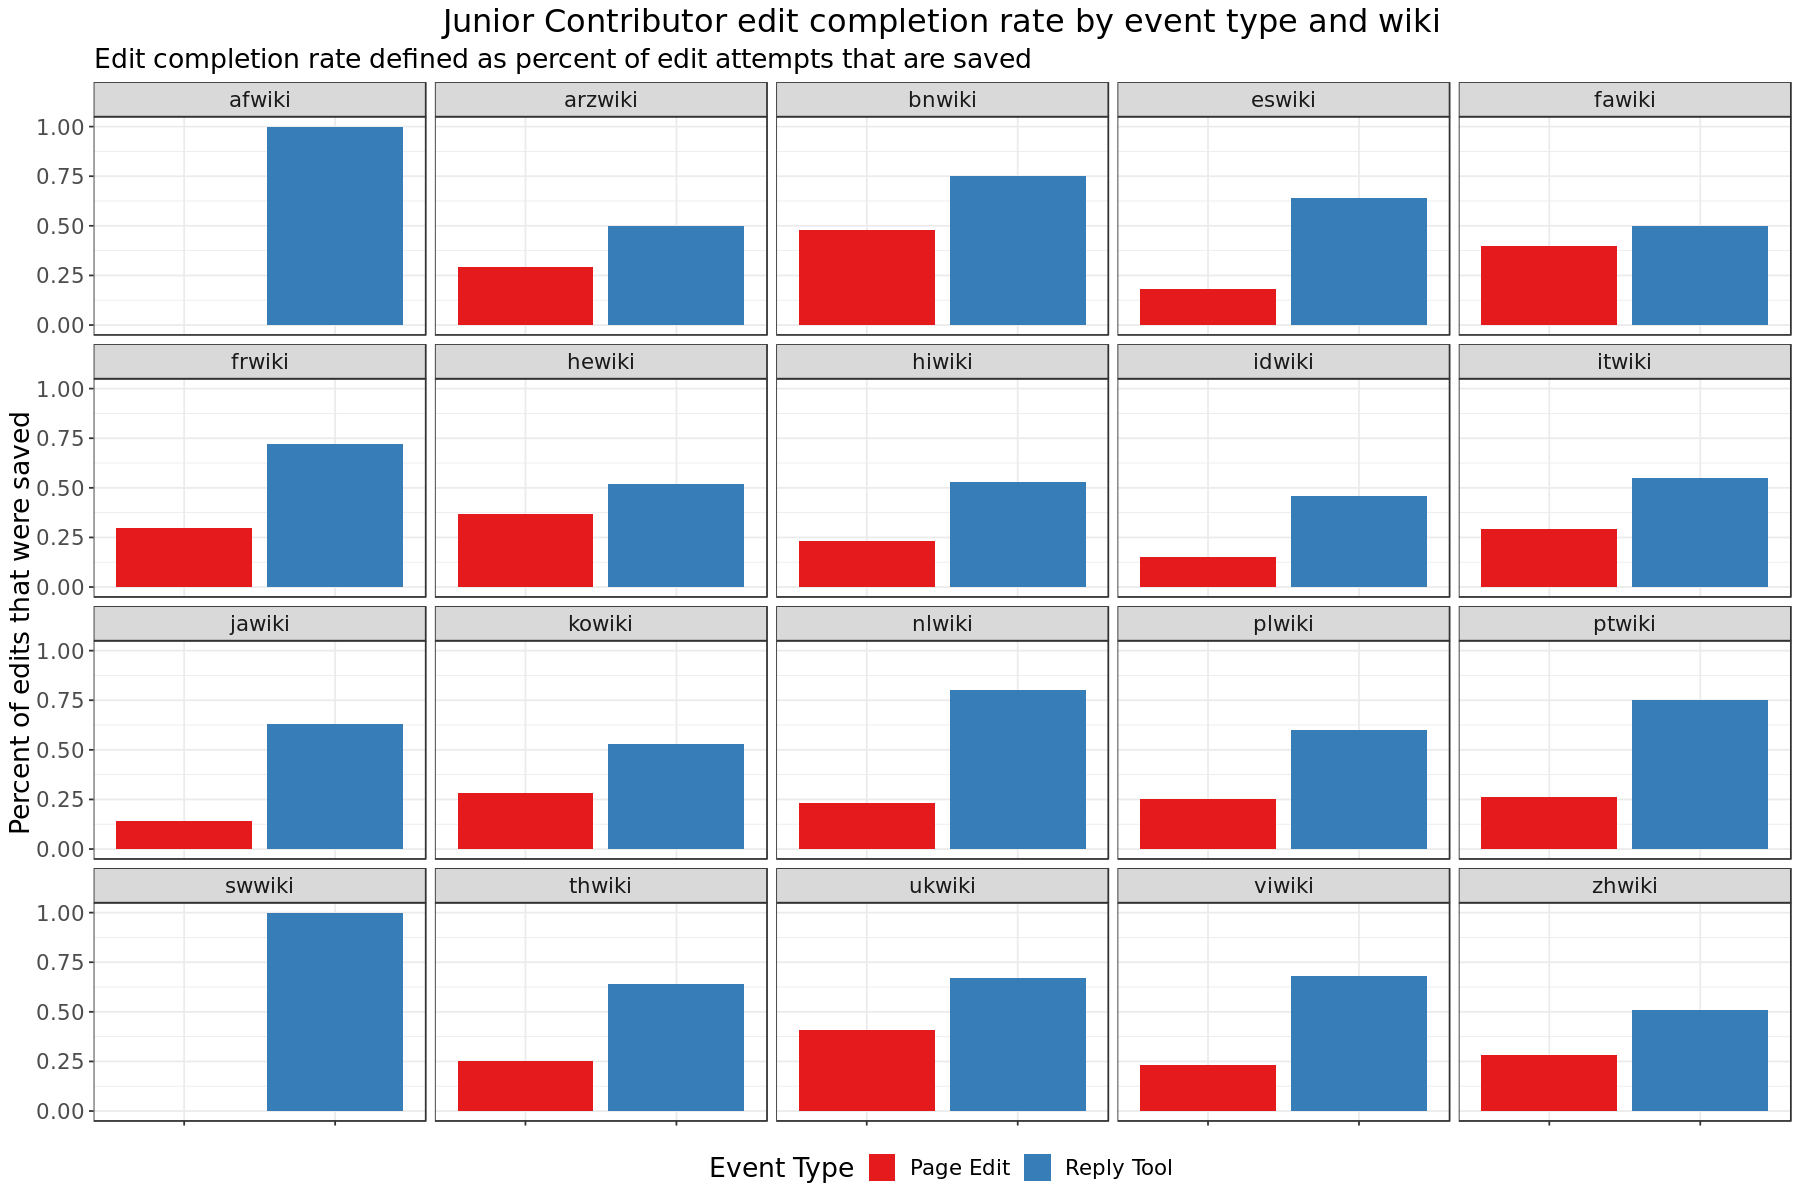

In [291]:
# Plot edit completion rates for each user on each wiki and each 

p <- ab_edit_attempts_bywiki_jc %>%
    ggplot(aes(x= editor_type, y = completion_rate, fill = editor_type)) +
    geom_col(position = 'dodge') +
    facet_wrap(~ wiki) +
    labs (y = "Percent of edits that were saved ",
          x = "Editor Type",
          title = "Junior Contributor edit completion rate by event type and wiki",
          subtitle = 'Edit completion rate defined as percent of edit attempts that are saved')  +
    theme_bw() +
    scale_fill_brewer(name="Event Type", palette="Set1")  +
    theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        legend.position = "bottom")
      
p

Junior Contributors are more likely to complete an edit using the reply tool compared to existing workflows.


In [292]:
# two-way contingency table of categorical outcome and predictors we want
## to make sure there are no 0 cells
xtabs(~edit_success + reply_tool_used, data = collect_ab_edit_attempts_jc)

            reply_tool_used
edit_success    0    1
           0 1550 2893
           1  417 1763

## Simple Linear Regression

In [293]:
ec_glm_jc <- glm(
    formula = edit_success ~ reply_tool_used, 
    family = binomial(link = 'logit'),
    data = collect_ab_edit_attempts_jc, 
             )

In [294]:
summary(ec_glm_jc)


Call:
glm(formula = edit_success ~ reply_tool_used, family = binomial(link = "logit"), 
    data = collect_ab_edit_attempts_jc)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9756  -0.9756  -0.6903   1.3937   1.7613  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -1.31292    0.05517   -23.8   <2e-16 ***
reply_tool_used  0.81765    0.06290    13.0   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 8392.4  on 6622  degrees of freedom
Residual deviance: 8209.9  on 6621  degrees of freedom
AIC: 8213.9

Number of Fisher Scoring iterations: 4


The simple logistic regression model estimates the coefficients as β0 = -1.31 and β1 = 0.818, where β0 is the intercept and β1 is the slope and effect associated with using the reply tool on completing an edit. 

Since the model parameters are on the log-odds scale, we take the exponentiation of the effect (exp(β1))to determine the multiplicative effect on the odds of an edit getting published

The estimates provided by the model indicate that odds of a user completing an edit with the reply tool is slightly higher (2.27 times – effectively double –) than the odds of a user completing an edit using  page or section editing; however, this does not take into account the effect of the user themselves or their experience.

In [297]:
ec_hrm_jc <- glmer(
  formula = edit_success ~ reply_tool_used + (1 | wiki/user_id),
  family = binomial(link = "logit"),
  data = collect_ab_edit_attempts_jc
)

boundary (singular) fit: see ?isSingular



In [298]:
summary(ec_hrm_jc)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: edit_success ~ reply_tool_used + (1 | wiki/user_id)
   Data: collect_ab_edit_attempts_jc

     AIC      BIC   logLik deviance df.resid 
  8214.3   8241.5  -4103.2   8206.3     6619 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.8143 -0.7666 -0.5278  1.2426  1.9986 

Random effects:
 Groups       Name        Variance Std.Dev.
 user_id:wiki (Intercept) 0.000000 0.00000 
 wiki         (Intercept) 0.006213 0.07882 
Number of obs: 6623, groups:  user_id:wiki, 2477; wiki, 20

Fixed effects:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -1.31298    0.05974  -21.98   <2e-16 ***
reply_tool_used  0.81493    0.06343   12.85   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
reply_tl_sd -0.793
optimizer (Nelder_Mead) convergence code: 0 (OK)
boun

## Bayesian Hierarchical Logistic Regression Model

In [295]:
ec_brm_jc <- brm(
  edit_success ~ reply_tool_used + (1 | wiki/user_id),
  family = bernoulli(link = "logit"),
  data = collect_ab_edit_attempts_jc,
  prior = priors,
  chains = 4, cores = 4
)


Compiling Stan program...

Start sampling



In [296]:
summary(ec_brm_jc)

 Family: bernoulli 
  Links: mu = logit 
Formula: edit_success ~ reply_tool_used + (1 | wiki/user_id) 
   Data: collect_ab_edit_attempts_jc (Number of observations: 6623) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Group-Level Effects: 
~wiki (Number of levels: 20) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.10      0.05     0.02     0.20 1.00     1364     1261

~wiki:user_id (Number of levels: 2477) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.03      0.02     0.00     0.09 1.00     2799     2187

Population-Level Effects: 
                Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept          -1.31      0.06    -1.44    -1.19 1.00     5494     2979
reply_tool_used     0.81      0.06     0.68     0.94 1.00     8323     2848

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
an

## Scratchpad

## Edit Completion Rate (Defined as number of users that complete at least one edit)

In [169]:
# Review user edit attempts by event type and wiki

ab_user_completion_rate_all <- collect_ab_edit_attempts %>%
    #filter(is_oversample == 'false') %>%
    group_by (editor_type, user_id) %>%
    summarise(n_completions = sum(edit_completed)) %>%
    ungroup() %>%
    group_by(editor_type) %>%
    summarise(n_users = n_distinct(user_id),
             n_users_completed = sum(n_completions >= 1),
             completion_rate = round(n_users_completed/n_users, 2))

ab_user_completion_rate_all

`summarise()` regrouping output by 'editor_type' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



editor_type,n_users,n_users_completed,completion_rate
<fct>,<int>,<int>,<dbl>
Page Edit,2646,1361,0.51
Reply Tool,2037,1400,0.69


In [171]:
# Review user edit attempts by event type and wiki

ab_user_completion_rate_bywiki <- collect_ab_edit_attempts %>%
    group_by (wiki, editor_type, user_id) %>%
    summarise(n_completions = sum(edit_completed)) %>%
    ungroup() %>%
    group_by(wiki, editor_type) %>%
    summarise(n_users = n_distinct(user_id),
             n_users_completed = sum(n_completions >= 1),
             completion_rate = round(n_users_completed/n_users, 2))

ab_user_completion_rate_bywiki

`summarise()` regrouping output by 'wiki', 'editor_type' (override with `.groups` argument)

`summarise()` regrouping output by 'wiki' (override with `.groups` argument)



wiki,editor_type,n_users,n_users_completed,completion_rate
<chr>,<fct>,<int>,<int>,<dbl>
afwiki,Page Edit,4,3,0.75
afwiki,Reply Tool,1,1,1.00
arzwiki,Page Edit,8,2,0.25
arzwiki,Reply Tool,3,2,0.67
bnwiki,Page Edit,28,16,0.57
bnwiki,Reply Tool,18,14,0.78
eswiki,Page Edit,423,198,0.47
eswiki,Reply Tool,322,230,0.71
fawiki,Page Edit,134,71,0.53


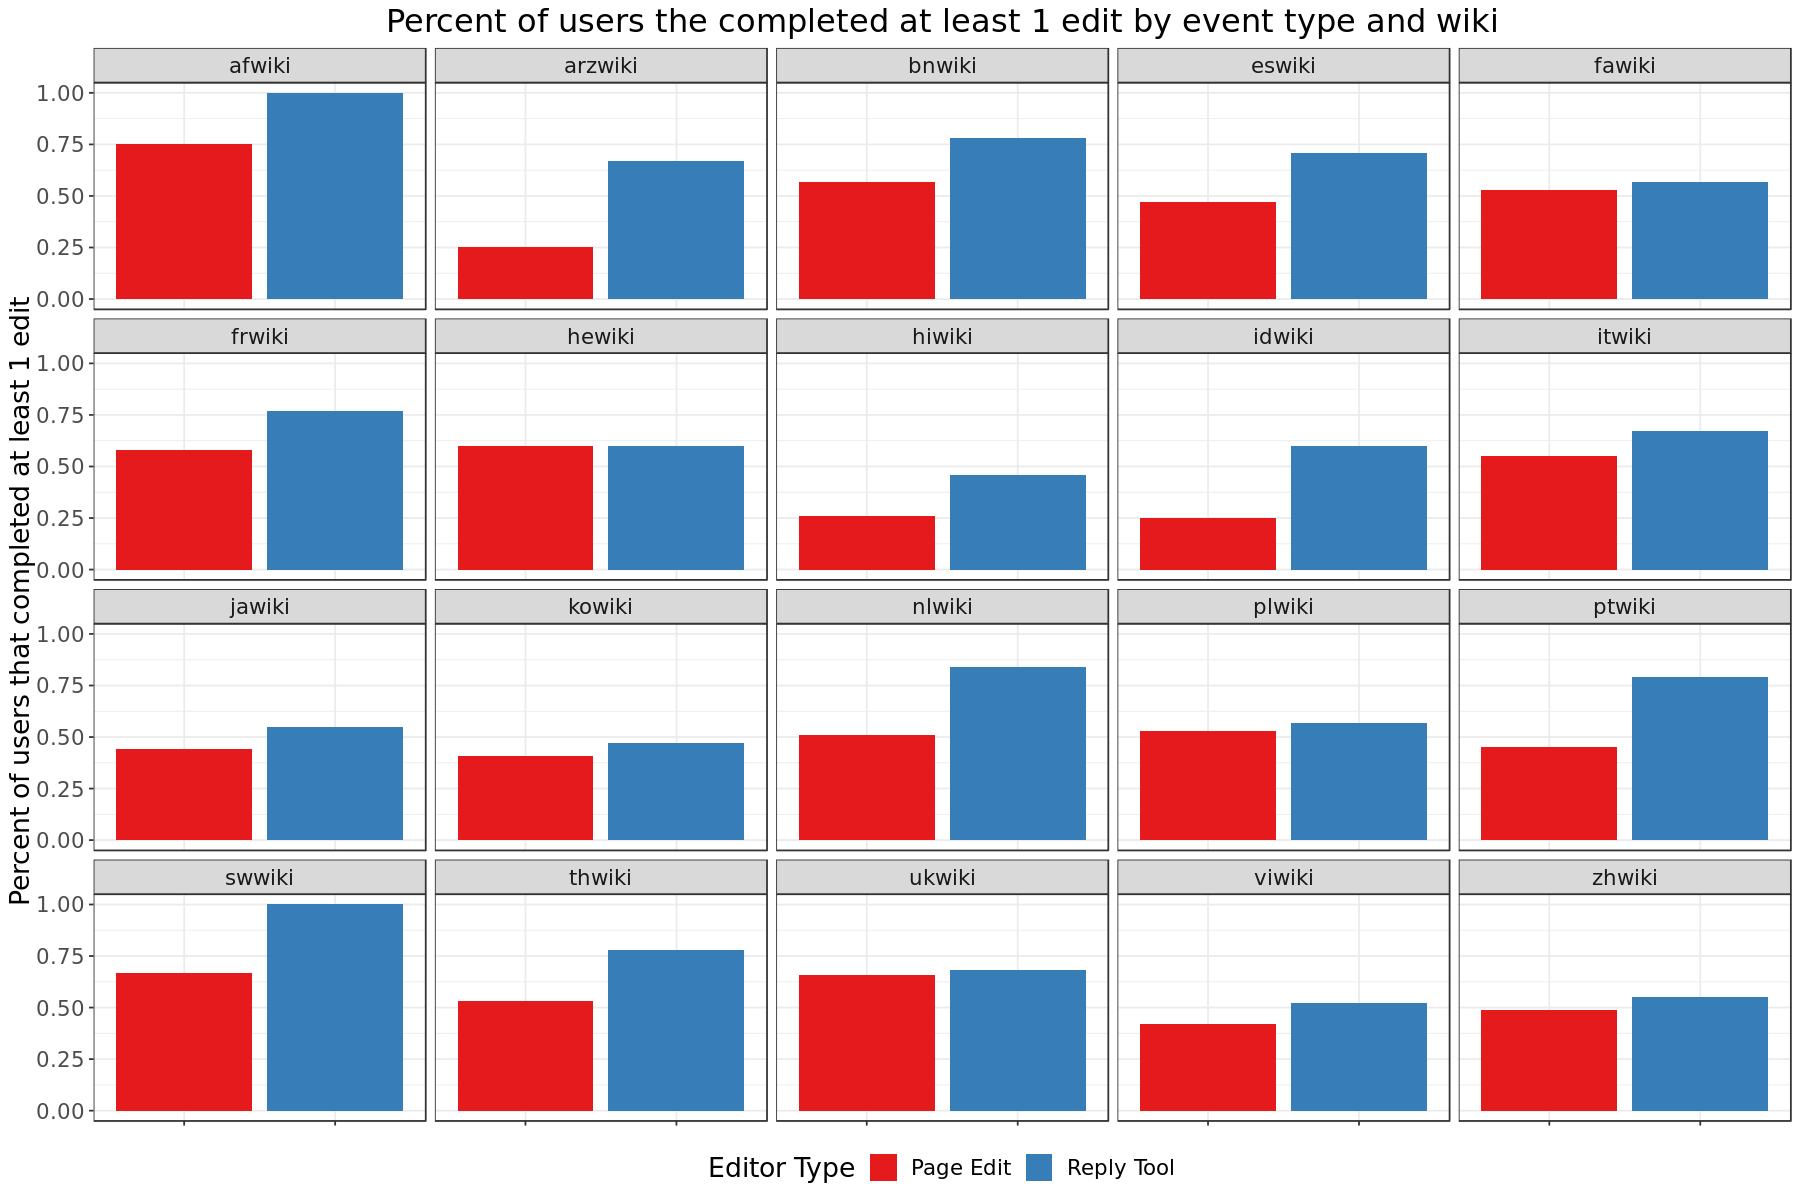

In [172]:
# Plot edit completion rates for each user on each wiki and each 

p <- ab_user_completion_rate_bywiki %>%
    ggplot(aes(x= editor_type, y = completion_rate, fill = editor_type)) +
    geom_col(position = 'dodge') +
    facet_wrap(~ wiki) +
    labs (y = "Percent of users that completed at least 1 edit",
              x = "Editor Type",
             title = "Percent of users the completed at least 1 edit by event type and wiki")  +
        theme_bw() +
        scale_fill_brewer(name="Editor Type", palette="Set1")  +
        theme(
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            legend.position = "bottom")
      

p